<a href="https://colab.research.google.com/github/alecishuman/Topic_Modelling_LDA/blob/main/LDA_The_Book_of_Negroes.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Paragraphs

## Preproccessing

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### Convert txt to documents

In [ ]:
book = open('/content/drive/MyDrive/ML Bootcamp Assignments/The_Book_of_Negroes_Story_Only.txt').read()

import re
book = book.replace('\n\n', 'PARAGRAPHBREAK')
book = book.replace('\n', ' ')
book = book.replace('\x0c', '')
book = re.sub('{.*?}', '', book)
book_list = book.split('PARAGRAPHBREAK')
book_list

def dialogueLine(line):
  #Identify dialogue lines and combine diagloue lines from the same dialogue
  return True

#Temporary solution
book_list.remove('And now I am old')
documents = []
for paragraph in book_list:
  if len(paragraph.split()) >= 30:
    documents.append(paragraph)
  else:
    documents[len(documents)-1] += paragraph

### Remove certain words and lemmatize

In [ ]:
import nltk
nltk.download('averaged_perceptron_tagger')

nltk.download('stopwords')
from nltk.corpus import stopwords
stopwords = set(stopwords.words('english'))

from nltk.tokenize import RegexpTokenizer
tokenizer = RegexpTokenizer(r'\w+')

nltk.download('wordnet')
from nltk.stem.wordnet import WordNetLemmatizer
lemmatizer = WordNetLemmatizer()

import spacy
nlp = spacy.load('en', disable=['parser', 'ner'])

#Get rid of proper nouns
# tagged_documents = []
# for document in documents:
#   tags = nltk.tag.pos_tag(document.split())
#   new_document = [word for word, tag in tags if tag != 'NNP' and tag != 'NNPS']
#   tagged_documents.append(' '.join(new_document))
# documents = tagged_documents

#Lemmatize
docs_out = []
postags=['NOUN', 'ADJ', 'VERB', 'ADV', 'PROPN']
for sent in documents:
  doc = nlp(" ".join(sent))
  docs_out.append([token.lemma_ for token in doc if token.pos_ in postags])

  #Remove entries with less than 2 characters
  docs_out = [[token for token in doc if len(token) > 2] for doc in docs_out]
  docs = docs_out


#Tokenize, remove stopwords and numbers
docs = [[token for token in tokenizer.tokenize(document.lower()) if token not in stopwords and not token.isnumeric()]
        for document in documents]

#Remove entries with less than 2 characters
docs = [[token for token in doc if len(token) > 2] for doc in docs]

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


### Adding some bigrams

In [ ]:
#Add only bigrams with 10+ occurences
from gensim.models import Phrases

bigram = Phrases(docs, min_count = 10)
for index in range(len(docs)):
  for token in bigram[docs[index]]:
    if '_' in token:
      docs[index].append(token)

/usr/local/lib/python3.7/dist-packages/gensim/models/phrases.py:598: UserWarning: For a faster implementation, use the gensim.models.phrases.Phraser class
  warnings.warn("For a faster implementation, use the gensim.models.phrases.Phraser class")


In [ ]:
from nltk.probability import FreqDist
processed_text = []
for doc in docs:
  processed_text += doc
fdist = FreqDist(processed_text)
top_ten = fdist.most_common(100)
top_ten

[('said', 1362),
 ('would', 655),
 ('one', 600),
 ('man', 553),
 ('could', 496),
 ('back', 447),
 ('men', 388),
 ('like', 351),
 ('time', 285),
 ('people', 279),
 ('asked', 276),
 ('two', 275),
 ('lindo', 246),
 ('georgia', 240),
 ('know', 238),
 ('day', 237),
 ('woman', 229),
 ('water', 222),
 ('came', 218),
 ('see', 210),
 ('town', 204),
 ('come', 203),
 ('white', 201),
 ('baby', 200),
 ('hand', 199),
 ('never', 197),
 ('around', 193),
 ('made', 192),
 ('clarkson', 188),
 ('way', 186),
 ('chekura', 185),
 ('women', 184),
 ('told', 183),
 ('night', 183),
 ('long', 180),
 ('head', 176),
 ('another', 172),
 ('even', 172),
 ('eyes', 171),
 ('let', 170),
 ('take', 166),
 ('saw', 164),
 ('still', 163),
 ('get', 158),
 ('away', 158),
 ('left', 157),
 ('took', 156),
 ('every', 156),
 ('negroes', 155),
 ('looked', 154),
 ('work', 152),
 ('knew', 150),
 ('say', 150),
 ('good', 149),
 ('home', 148),
 ('fomba', 147),
 ('brought', 145),
 ('right', 145),
 ('fanta', 143),
 ('new', 141),
 ('appleby'

## Modelling

### Filtering extremes and vectorizing to bag of words

In [ ]:
from gensim.corpora import Dictionary
dictionary = Dictionary(docs)
dictionary.filter_extremes(no_below = 3, no_above = 0.5)

corpus = [dictionary.doc2bow(doc) for doc in docs]

print('Number of unique tokens: %d' % len(dictionary))
print('Number of documents: %d' % len(corpus))

Number of unique tokens: 3549
Number of documents: 1272


### Set parameters for models

In [ ]:
#Set parameters
num_topics = 50
chunksize = 1000
passes = 30
iterations = 600
eval_every = None

temp = dictionary[0]
id2word = dictionary.id2token

### Transform bag of words to tfidf

In [ ]:
#tfidf model
from gensim import models
tfidf = models.TfidfModel(corpus)
corpus_tfidf = tfidf[corpus]

### Train TF-IDF model + results

In [ ]:
#TF-IDF model with LdaMulticore
from gensim.models import LdaMulticore
model_tfidf = LdaMulticore(
    corpus = corpus_tfidf,
    id2word = id2word,
    chunksize = chunksize,
    iterations = iterations,
    num_topics = num_topics,
    passes = passes,
    eval_every = eval_every
)

top_topics_tfidf = model_tfidf.top_topics(corpus)

avg_topic_coherence = sum([t[1] for t in top_topics_tfidf]) / num_topics
print('Average topic coherence: %.4f.' % avg_topic_coherence)

from pprint import pprint
pprint(top_topics_tfidf)

Average topic coherence: -13.1949.
[([(0.010809397, 'would'),
   (0.009183956, 'men'),
   (0.008722012, 'one'),
   (0.008626075, 'man'),
   (0.008184731, 'back'),
   (0.008016417, 'could'),
   (0.0067641367, 'people'),
   (0.0065235444, 'like'),
   (0.006296488, 'time'),
   (0.0062433546, 'georgia'),
   (0.006199708, 'woman'),
   (0.006051264, 'women'),
   (0.005971813, 'water'),
   (0.0059270607, 'come'),
   (0.0058916933, 'two'),
   (0.005841699, 'around'),
   (0.00574525, 'know'),
   (0.0056011635, 'still'),
   (0.0055897427, 'baby'),
   (0.00545997, 'told')],
  -1.7367283820635138),
 ([(0.009838055, 'british'),
   (0.009296962, 'dolly'),
   (0.008651927, 'town'),
   (0.008548117, 'birchtown'),
   (0.008076953, 'daughter'),
   (0.007957418, 'done'),
   (0.0075974893, 'work'),
   (0.0075371647, 'africa'),
   (0.00724178, 'run'),
   (0.007208341, 'made'),
   (0.007115545, 'body'),
   (0.007091051, 'bed'),
   (0.00708381, 'tell'),
   (0.006415701, 'leave'),
   (0.006340351, 'sure'),
  

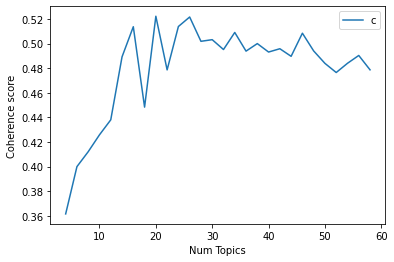

In [ ]:
#Plot TF-IDF Coherence values
from gensim.models import CoherenceModel
import matplotlib.pyplot as plt
%matplotlib inline

def get_coherence_values(dictionary, corpus, texts, max_topics, start, step):
  coherence_values = []
  models = []
  for topic_num in range(start, max_topics, step):
    model = LdaMulticore(
      corpus = corpus,
      id2word = id2word,
      chunksize = chunksize,
      iterations = iterations,
      num_topics = topic_num,
      passes = passes,
      eval_every = eval_every
    )
    models.append(model)
    coherencemodel = CoherenceModel(model = model, texts = texts, dictionary = dictionary, coherence = 'c_v')
    coherence_values.append(coherencemodel.get_coherence())
  return models, coherence_values

model_list, coherence_values = get_coherence_values(dictionary = dictionary, corpus = corpus_tfidf, texts = docs, max_topics = 60, start = 4, step = 2)
max_topics = 60; start = 4; step = 2;
x = range(start, max_topics, step)
plt.plot(x, coherence_values)
plt.xlabel('Num Topics')
plt.ylabel('Coherence score')
plt.legend(('coherence_values'), loc='best')
plt.show()

## Links and References:
https://litlab.stanford.edu/LiteraryLabPamphlet10.pdf

https://towardsdatascience.com/topic-modeling-and-latent-dirichlet-allocation-in-python-9bf156893c24

https://radimrehurek.com/gensim/auto_examples/core/run_topics_and_transformations.html#sphx-glr-auto-examples-core-run-topics-and-transformations-py

https://towardsdatascience.com/topic-modeling-and-latent-dirichlet-allocation-in-python-9bf156893c24

https://radimrehurek.com/gensim/auto_examples/tutorials/run_lda.html

https://medium.com/swlh/topic-modeling-lda-mallet-implementation-in-python-part-2-602ffb38d396

https://www.machinelearningplus.com/nlp/gensim-tutorial/

In [ ]:
# Notes about potential improvements:
# - Include pronous
# - Better lemmatization (especially verbs)
# - Higher number of topics
# - Look at character groupings
# - Topic with character association
# - Doc2Vec